In [203]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import copy
from scipy import stats
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from scipy.stats import wilcoxon
%matplotlib widget

In [204]:
def load_res(TRUELABEL_PERCENT, table_path, nb_subj, SEEDS, track_resolu, label_resolu, mm_resolu, coe, MAX_ITER, LWCOV, KEEP_TRAIN_PERCENT, BOOTSTRAP):
    rt = np.zeros((nb_subj, MAX_ITER))
    corr_sum = np.zeros((nb_subj, MAX_ITER))
    acc = np.zeros((nb_subj, MAX_ITER))
    rt_list = []
    corr_sum_list = []
    acc_list = []
    for SEED in SEEDS:
        if TRUELABEL_PERCENT == 0.0 or TRUELABEL_PERCENT == 1.0:
            SEED = SEEDS[0]
        for Subj_ID in range(nb_subj):
            file_name = f'{table_path}{Subj_ID}_singleenc_trackresolu{track_resolu}_truelabelpct_{TRUELABEL_PERCENT}_labelresolu_{label_resolu}_mmresolu_{mm_resolu}coe{coe}_nbiter{MAX_ITER}_seed{SEED}{'_lwcov' if LWCOV else ''}{KEEP_TRAIN_PERCENT if KEEP_TRAIN_PERCENT is not None else ''}{'_bootstrap' if BOOTSTRAP else ''}.pkl'
            with open(file_name, 'rb') as f:
                res = pickle.load(f)
                rt[Subj_ID,:] = res['rt_list']
                corr_sum[Subj_ID,:] = res['corr_sum_list']
                acc[Subj_ID,:] = res['acc_list']
        rt_list.append(copy.deepcopy(rt))
        corr_sum_list.append(copy.deepcopy(corr_sum))
        acc_list.append(copy.deepcopy(acc))
    rt_avg_over_seeds = np.mean(rt_list, axis=0)
    corr_avg_over_seeds = np.mean(corr_sum_list, axis=0)
    acc_avg_over_seeds = np.mean(acc_list, axis=0)   
    rt_all = np.concatenate(tuple(rt_list), axis=0) 
    corr_all = np.concatenate(tuple(corr_sum_list), axis=0)
    acc_all = np.concatenate(tuple(acc_list), axis=0)   
    return rt_avg_over_seeds, corr_avg_over_seeds, acc_avg_over_seeds, rt_all, corr_all, acc_all

In [205]:
SEEDS = [2, 4, 8, 16, 32]
# SEEDS = [4]
label_resolu = 60
track_resolu = 60
mm_resolu = 60
MAX_ITER = 6
LWCOV = False
BOOTSTRAP = True
KEEP_TRAIN_PERCENT = None
coe = 1.0

In [206]:
MOD = 'EEG-EOG'
nb_subj = 19
L_data = 3
L_feats = 15
w_data = np.zeros((nb_subj, 64*L_data, 5))
w_feats = np.zeros((nb_subj, L_feats, 5)) 
table_path = f'tables/{MOD}/'

## Plot the initial results for each TRUELABEL_PERCENT

In [109]:
TRUELABEL_PERCENT_list = [0.0, 0.25, 0.5, 0.75, 1.0]
rt_init = np.zeros((nb_subj*len(SEEDS), len(TRUELABEL_PERCENT_list)))
corr_init = np.zeros((nb_subj*len(SEEDS), len(TRUELABEL_PERCENT_list)))
acc_init = np.zeros((nb_subj*len(SEEDS), len(TRUELABEL_PERCENT_list)))
for i, TRUELABEL_PERCENT in enumerate(TRUELABEL_PERCENT_list):
    rt_avg_over_seeds, corr_avg_over_seeds, acc_avg_over_seeds, rt_all, corr_all, acc_all =  load_res(TRUELABEL_PERCENT, table_path, nb_subj, SEEDS, track_resolu, label_resolu, mm_resolu, coe, MAX_ITER, LWCOV, KEEP_TRAIN_PERCENT, BOOTSTRAP)
    rt_init[:,i] = rt_all[:,0]
    corr_init[:,i] = corr_all[:,0]
    acc_init[:,i] = acc_all[:,0]

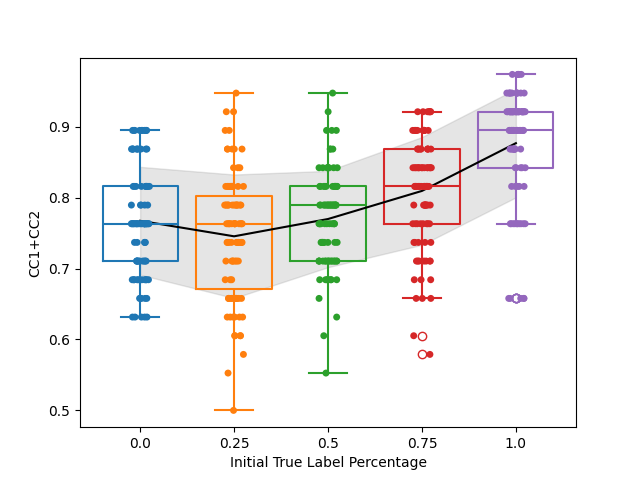

In [110]:
value_to_plot = rt_init
plt.close('all')
plt.figure()
sns.boxplot(data=value_to_plot, fill=None)
sns.stripplot(data=value_to_plot)
plt.plot(np.mean(value_to_plot, axis=0), color='black')
plt.fill_between(range(len(TRUELABEL_PERCENT_list)), np.mean(value_to_plot, axis=0) - np.std(value_to_plot, axis=0), np.mean(value_to_plot, axis=0) + np.std(value_to_plot, axis=0), color='gray', alpha=0.2)
plt.xticks(ticks=range(len(TRUELABEL_PERCENT_list)), labels=[f'{TRUELABEL_PERCENT}' for TRUELABEL_PERCENT in TRUELABEL_PERCENT_list])
plt.xlabel('Initial True Label Percentage')
plt.ylabel('CC1+CC2')
plt.show()

In [97]:
np.mean(value_to_plot, axis=0)

array([0.04545824, 0.05928133, 0.06643578, 0.07415463, 0.07677091])

In [18]:
wilcoxon(acc_init[:,4], acc_init[:,3], alternative='greater')

WilcoxonResult(statistic=np.float64(2452.5), pvalue=np.float64(0.11089408228177855))

## Plot the results of each iteration for a given initial TRUELABEL_PERCENT

In [207]:
TRUELABEL_PERCENT = 0.0
rt_avg_over_seeds, corr_avg_over_seeds, acc_avg_over_seeds, rt_all, corr_all, acc_all = load_res(TRUELABEL_PERCENT, table_path, nb_subj, SEEDS, track_resolu, label_resolu, mm_resolu, coe, MAX_ITER, LWCOV, KEEP_TRAIN_PERCENT, BOOTSTRAP)

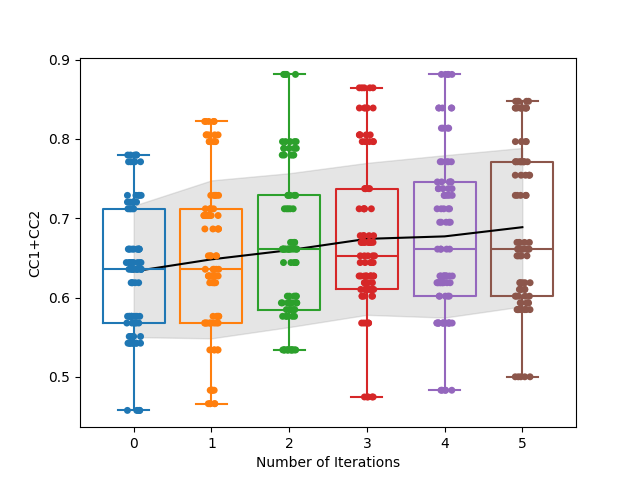

In [208]:
value_to_plot = acc_all # Choose between rt_all, corr_all, acc_all
plt.close('all')
plt.figure()
sns.boxplot(data=value_to_plot, fill=None)
sns.stripplot(data=value_to_plot)
plt.plot(np.mean(value_to_plot, axis=0), color='black')
plt.fill_between(range(MAX_ITER), np.mean(value_to_plot, axis=0) - np.std(value_to_plot, axis=0), np.mean(value_to_plot, axis=0) + np.std(value_to_plot, axis=0), color='gray', alpha=0.2)
plt.xlabel('Number of Iterations')
plt.ylabel('CC1+CC2')
plt.show()

In [209]:
np.mean(value_to_plot, axis=0)

array([0.63291704, 0.64808207, 0.65967886, 0.67395183, 0.67707404,
       0.68867083])

In [146]:
wilcoxon(value_to_plot[:,1], value_to_plot[:,0], alternative='greater')

WilcoxonResult(statistic=np.float64(3032.5), pvalue=np.float64(0.0025998891931597276))